<a href="https://colab.research.google.com/github/AnanLu/PHYS641_2022_solution/blob/main/PS3/PS3_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from scipy import fft
import time

## Check map

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


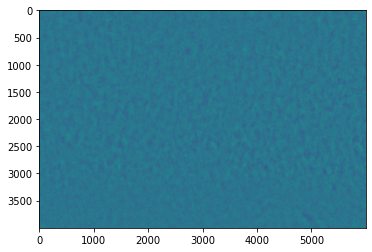

In [ ]:
hdul=fits.open('./drive/MyDrive/Fall_2022/PHYS641/problem_sets/PS3/advact_tt_patch.fits')
map=hdul[0].data
hdul.close()
map=np.asarray(map,dtype='float')
plt.imshow(map)

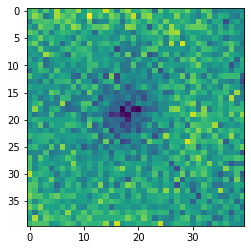

In [ ]:
x0=2000
y0=3000
width=20
patch=map[x0-width:x0+width,y0-width:y0+width]
plt.imshow(patch)

In [ ]:
map[2000,3000]

-200.0

## Part 1: fit a gaussian

In [ ]:
def mygauss(pars,width):
    vec=np.asarray(np.arange(-width,width),dtype='float')
    amp=pars[0]
    dx=pars[1]
    dy=pars[2]
    sig=pars[3]
    bg=pars[4]

    xvec=vec-dx
    yvec=vec-dy
    xmat=np.outer(xvec,np.ones(len(xvec)))
    ymat=np.outer(np.ones(len(yvec)),yvec)
    rmat=xmat**2+ymat**2
    model=np.exp(-0.5*(rmat/sig**2))*amp+bg

    return model

def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model,derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model,derivs_out

def newton(pars,data,fun,width,dpar,niter=10):
    for i in range(niter):
        model,derivs=get_model_derivs_ravel(fun,pars,dpar,width)
        resid=data-model
        lhs=derivs.T@derivs
        rhs=derivs.T@resid
        shift=np.linalg.inv(lhs)@rhs
        print('parameter shifts are ',shift)
        # print('parameters are ',pars)
        pars=pars+shift
    return pars

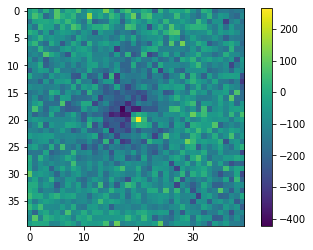

chisq improvement is  110.46832760077314
parameter shifts are  [ 118.11750191   -1.02067658   -1.80382113    1.82808436 -191.55444633]
parameter shifts are  [-122.3301878    -0.64096225   -1.79510078    0.83252186    6.77204299]
parameter shifts are  [23.8421638   0.27466518  1.01942123  0.16840142  2.84070745]
parameter shifts are  [-10.17058891  -0.013789    -0.07257722  -0.22658721  -0.74402381]
parameter shifts are  [-2.51047497  0.0314086   0.07596232 -0.05204675 -0.19880647]
parameter shifts are  [-1.21964201  0.00622531  0.00234313 -0.03361905 -0.13535784]
parameter shifts are  [-0.47144689  0.00485287  0.00809557 -0.01302598 -0.05256576]
parameter shifts are  [-0.22958882  0.00181997  0.00213837 -0.00646128 -0.02628976]
parameter shifts are  [-0.10176433  0.00092716  0.00130622 -0.00287317 -0.01171577]
parameter shifts are  [-0.04753354  0.00040927  0.00053298 -0.00134527 -0.00549277]


In [ ]:
sig=1.0  #Gaussian sigma
xshift=0.0 #sub-pixel x-shift guess
yshift=0.0 #sub-pixel y-shift guess

dx=np.arange(-width,width)
dxmat=np.outer(dx,np.ones(len(dx)))
dymat=dxmat.T

drsqr=(dxmat-xshift)**2+(dymat-yshift)**2
mymodel=np.exp(-0.5*drsqr/sig**2)*-10
#the least-squares best-fit amplitude for constant noise
amp=np.sum(mymodel*patch)/np.sum(mymodel**2)

resid=patch-mymodel*amp


# plt.figure(2)
# plt.clf()
plt.imshow(resid)
plt.colorbar()
plt.show()
# plt.savefig('patch_modsub.png')

n=np.std(resid)
chi1=np.sum(patch**2/n**2)
chi2=np.sum(resid**2/n**2)
dchi=chi1-chi2
print('chisq improvement is ',dchi)

pars=np.asarray([-200,0,0,2,100],dtype='float')
dpar=np.asarray([-1.0,0.001,0.001,0.01,0.01])/10

fitp=newton(pars,np.ravel(patch),mygauss,width,dpar)
mymod=mygauss(fitp,width)
fit_chisq=np.sum((patch-mymod)**2/n**2)
# print('best-fit chisq is ',fit_chisq)
# plt.clf()
# plt.imshow(patch-mymod)
# plt.colorbar()
# plt.show()
# plt.savefig('act_patch_modfit.png')

[-195.12156156   -1.35511946   -2.56169929    4.49304894  -83.11594806]
best-fit amplitude is  -195.12156156279318
best-fit x position is  1998.6448805354987
best-fit y position is  2997.438300706647
best-fit sigma is  4.493048939337141
best-fit chisq is  1287.1849269696781


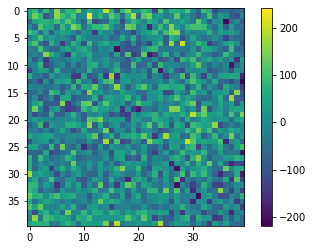

In [ ]:
# plt.imshow(mymod)
plt.imshow(patch-mymod)
print(fitp)
print('best-fit amplitude is ', fitp[0])
print('best-fit x position is ', x0+fitp[1])
print('best-fit y position is ', y0+fitp[2])
print('best-fit sigma is ', fitp[3])
print('best-fit chisq is ',fit_chisq)
plt.colorbar()
plt.show()

## Part 2: 2D power spectrum

In [ ]:
def pad_map(map):
    map=np.hstack([map,np.fliplr(map)])
    map=np.vstack([map,np.flipud(map)])
    return map

def get_gauss_kernel(sig,map,norm=False):
    nx=map.shape[0]
    x=np.fft.fftfreq(map.shape[0])*map.shape[0]
    y=np.fft.fftfreq(map.shape[1])*map.shape[1]
    rsqr=np.outer(x**2,np.ones(map.shape[1]))+np.outer(np.ones(map.shape[0]),y**2)
    kernel=np.exp((-0.5/sig**2)*rsqr)
    if norm:
        kernel=kernel/kernel.sum()
    return kernel

def smooth_map(map,sig):
    kernel=get_gauss_kernel(sig,map,True)
    mapft=fft.rfft2(map,workers=8)
    kernelft=fft.rfft2(kernel,workers=8)
    return fft.irfft2(mapft*kernelft,workers=8)

def estimate_ps(map,sig):
    mapft=fft.fft2(pad_map(map),workers=8)
    ps=smooth_map(np.abs(mapft)**2,sig)
    return ps

In [ ]:
ps=estimate_ps(map,sig=4)

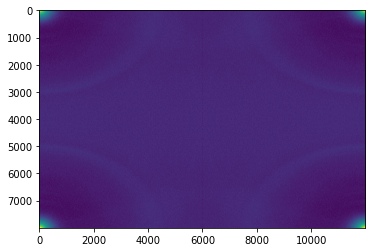

In [ ]:
plt.imshow(np.log10(ps))

## Part 3: Filter map

In [ ]:
def filter_map(map,ps):
    patch_padded = pad_map(map)
    mapft=fft.fft2(patch_padded,workers=8)
    map_filt=np.real(fft.ifft2(mapft/ps,workers=8))*(patch_padded**2).sum() ## added normalization factor
    return map_filt[:map.shape[0],:map.shape[1]]

In [ ]:
map_filt=filter_map(map,ps)
patch_filt = map_filt[x0-width:x0+width,y0-width:y0+width]

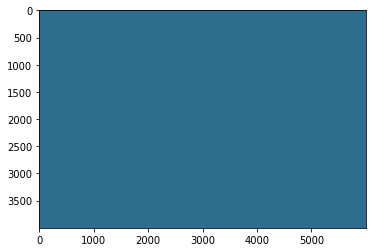

In [ ]:
plt.imshow(map_filt)

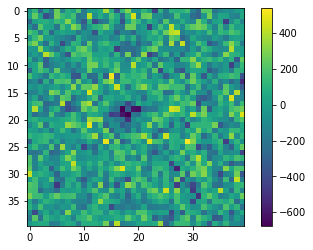

In [ ]:
plt.imshow(patch_filt)
plt.colorbar()

## Part 4: test on white noise

In [ ]:
white_map = np.random.randn(map.shape[0],map.shape[1])

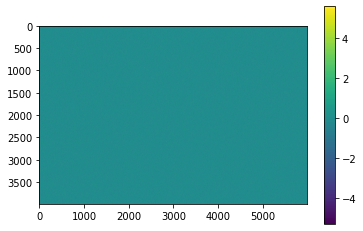

In [ ]:
plt.imshow(white_map)
plt.colorbar()

In [ ]:
ps_test=estimate_ps(white_map,sig=4)
map_filt_t=filter_map(white_map,ps_test)

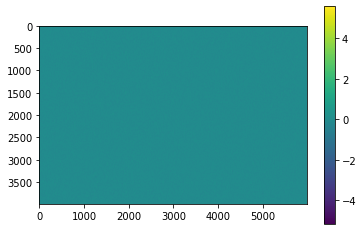

In [ ]:
plt.imshow(map_filt_t)
plt.colorbar()

In [ ]:
np.var(map_filt_t)

0.9906877880312794

## Part 5: matched filter

In [ ]:
sig=4
t1=time.time();kernel=get_gauss_kernel(sig,ps);t2=time.time()

mapft=fft.fft2(pad_map(map),workers=8)
kernelft=fft.fft2(kernel,workers=8)
kernel_filt=np.real(fft.ifft2(kernelft/ps))#[:kernel.shape[0],:kernel.shape[1]]
lhs=np.sum(kernel*kernel_filt)
rhs=np.real(fft.ifft2((kernelft)*mapft/ps))
rhs=rhs[:map.shape[0],:map.shape[1]]

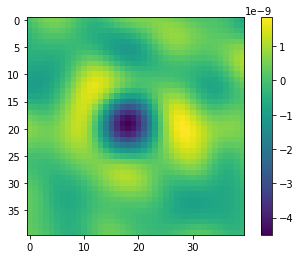

In [ ]:
patch_mf = rhs[x0-width:x0+width,y0-width:y0+width]
plt.imshow(patch_mf)
plt.colorbar()

The amplitude seems to be -196.92931428761048 micro K
The uncertainty is 36.437988441987244 micro K


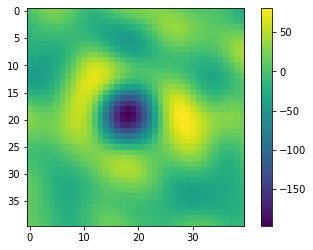

In [ ]:
amp = rhs/lhs
patch_err = np.std(amp[x0-width:x0+width,y0-width:y0+width])

plt.imshow(amp[x0-width:x0+width,y0-width:y0+width])
plt.colorbar()

print('The amplitude seems to be', np.min(amp[x0-width:x0+width,y0-width:y0+width]), 'micro K')
print('The uncertainty is', patch_err, 'micro K')

## Part 6: Other clusters?

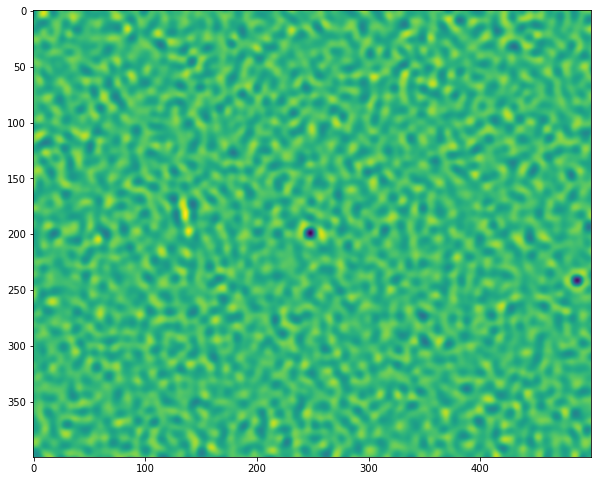

In [ ]:
patch_L = rhs[x0-200:x0+200,y0-250:y0+250]
# plt.imshow(patch_L)
# plt.colorbar()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(patch_L)

# ax.imshow